# Start
Bunch of people traveling in a spaceship and something happend where a group was **Transported** to a different reality.

👉Goal. To predict the passengers that were **Transported** to a different reality.

[kaggle](https://www.kaggle.com/code/fiftythirtyfour/spaceship-titanic)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

## Organize Columns
target = 'Transported'
num = [x for x in df.columns if df.dtypes[x] in ['float64']]
cat = [x for x in df.columns if df.dtypes[x] == 'object']
cat.remove('PassengerId')

## Train Test Split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=0)

# Explore
- People in Cryo-Sleep were most likely transported.
- Rich people who used Roomservice, VRDeck and Spa were less likely to be transported.

## TODO
- Check the Passenger Id Group prefix

In [2]:
train[target].mean()

0.5035950532067874

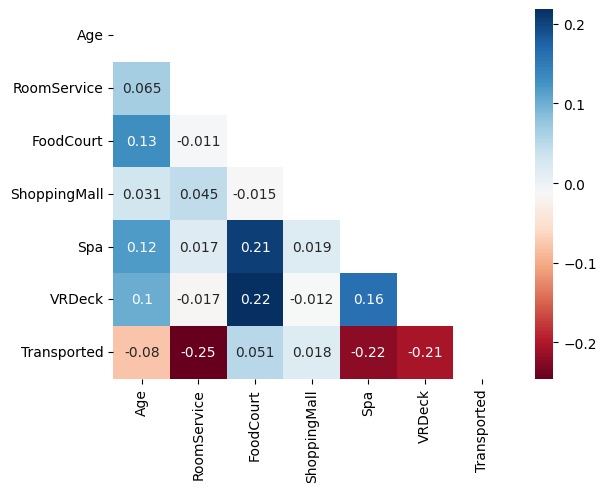

In [3]:
g = train[num + [target]].corr()
np.fill_diagonal(g.values, 0)
mask = np.triu(np.ones_like(g, dtype=bool))
sns.heatmap(g, annot=True, cmap='RdBu', mask=mask);

In [4]:
train.groupby('HomePlanet')[target].mean()

HomePlanet
Earth     0.427280
Europa    0.660422
Mars      0.512856
Name: Transported, dtype: float64

In [5]:
train.groupby('CryoSleep')[target].agg(['mean', 'sum', 'count'])

,mean,sum,count
CryoSleep,,,
False,0.328516,1432,4359
True,0.819381,1987,2425


In [6]:
train.isnull().mean()

PassengerId     0.000000
HomePlanet      0.022433
CryoSleep       0.024446
Cabin           0.021714
Destination     0.021427
Age             0.020995
VIP             0.025309
RoomService     0.021714
FoodCourt       0.021283
ShoppingMall    0.024734
Spa             0.021858
VRDeck          0.020995
Name            0.022433
Transported     0.000000
dtype: float64

In [7]:
train.groupby('Destination')[target].agg(['mean', 'sum', 'count'])

,mean,sum,count
Destination,,,
55 Cancri e,0.614525,880,1432
PSO J318.5-22,0.514469,320,622
TRAPPIST-1e,0.468954,2228,4751


# Feature Engineering

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes]

# Pipeline

In [10]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
cat_pp = Pipeline([
    ('dataselect', DataSelect(['CryoSleep']))
#     , ('impute', SimpleImputer(strategy='constant', fill_value='empty'))
    , ('encoder', OneHotEncoder(sparse_output=False))
])

num_pp = Pipeline([
    ('dataselect', DataSelect(num))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

pipe = FeatureUnion([
    ('cat', cat_pp)
    , ('num', num_pp)
])

pipe.fit(train)
train_pp = pipe.transform(train)
test_pp = pipe.transform(test)

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

In [13]:
gnb = GaussianNB()
gnb.fit(train_pp, train[target])
cross_val_score(gnb, train_pp, train[target]).mean()

0.7329603980367108

In [14]:
svc = SVC()
svc.fit(train_pp, train[target])
cross_val_score(svc, train_pp, train[target]).mean()

0.7909110468634439

In [15]:
dcs = DecisionTreeClassifier()
dcs.fit(train_pp, train[target])
cross_val_score(dcs, train_pp, train[target]).mean()

0.7388527481393748

In [16]:
rfc = RandomForestClassifier()
rfc.fit(train_pp, train[target])
cross_val_score(rfc, train_pp, train[target]).mean()

0.7860220637293185

In [17]:
model_base = svc

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
# params = {
#     "kernel": ["poly"]
#     , "degree": [1, 10]
#     , "coef0": [1, 50]
#     , "C": [5]
# }

# grd = GridSearchCV(model_base, param_grid=params)
# grd.fit(train_pp, train[target])
# grd.best_params_

In [20]:
model_tune = SVC(kernel='poly', degree=3, coef0=1, C=5)
model_tune.fit(train_pp, train[target]);

## Validation

In [21]:
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [22]:
accuracy_score(train[target], cross_val_predict(model_base, train_pp, train[target]))

0.7909117054932413

In [23]:
precision_score(train[target], cross_val_predict(model_base, train_pp, train[target]))

0.7907438955139126

In [24]:
recall_score(train[target], cross_val_predict(model_base, train_pp, train[target]))

0.7952598515134209

In [25]:
accuracy_score(test[target], cross_val_predict(model_base, test_pp, test[target]))

0.7745830937320299

In [26]:
precision_score(test[target], cross_val_predict(model_base, test_pp, test[target]))

0.7775229357798165

In [27]:
recall_score(test[target], cross_val_predict(model_base, test_pp, test[target]))

0.773972602739726

In [28]:
tune_prediction_tr = cross_val_predict(model_tune, train_pp, train[target])
tune_prediction_te = cross_val_predict(model_tune, test_pp, test[target])

In [29]:
accuracy_score(train[target], tune_prediction_tr)

0.7970951970089157

In [30]:
precision_score(train[target], tune_prediction_tr)

0.7854217854217854

In [31]:
recall_score(train[target], tune_prediction_tr)

0.8215305539691605

In [32]:
accuracy_score(test[target], tune_prediction_te)

0.7740080506037953

In [33]:
precision_score(test[target], tune_prediction_te)

0.764512595837897

In [34]:
recall_score(test[target], tune_prediction_te)

0.7968036529680366

## Submission

In [35]:
samp = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
pd.DataFrame({
    "PassengerId": samp["PassengerId"]
    , "Transported": model_tune.predict(pipe.transform(samp))
}).to_csv('submission.csv', index=False)